In [1]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.cluster
import sklearn.svm
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import functools
import collections
import joblib
import local_models.loggin
import local_models.TLS_models
import local_models.utils
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR
from sklearn import datasets, svm, metrics
import cv2

logger = logging.getLogger(__name__)

np.random.seed(1)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
font = {'size'   : 18}

mpl.rc('font', **font)

In [3]:
digits = datasets.load_digits()

In [4]:
mnist = sklearn.datasets.fetch_openml('mnist_784')

In [5]:
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [6]:
mnist_resized = np.stack([cv2.resize(mnist.data[i].reshape(28, 28), (8,8)) for i in range(mnist.data.shape[0])], axis=0)

In [7]:
mnist_resized = mnist_resized.reshape(mnist.data.shape[0], -1)

In [8]:
RUN = 4
project_dir = "../data/local_svm_mnist_{:02d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

In [9]:
images_and_labels = list(zip(mnist.data, mnist.target))

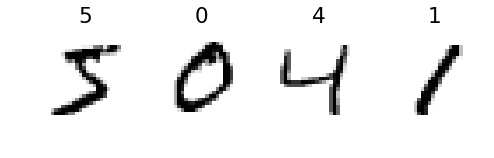

In [10]:
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('{}'.format(label))

In [11]:
n_samples = mnist.data.shape[0]
data = mnist.data

In [12]:
subsample_rate = 0.1

In [13]:
SEED=1
subsampled_data, _, subsampled_labels, _ = sklearn.model_selection.train_test_split(
    data, mnist.target, test_size=1-subsample_rate, random_state=SEED, stratify=mnist.target)

In [14]:
SEED=1
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(
    subsampled_data, subsampled_labels, test_size=0.3, random_state=SEED)

In [15]:
model = sklearn.svm.LinearSVC(C=3000., dual=False)
index = sklearn.neighbors.KDTree(train_data, leaf_size=4)

In [16]:
linear_models = local_models.local_models.LocalModels(model)
linear_models.fit(train_data, train_labels, index=index)

In [17]:
dz, iz = linear_models.index.query(train_data, k=2)

In [18]:
avg_1nn_dist = np.average(dz[:,1])

In [19]:
kernel = local_models.local_models.TriCubeKernel(bandwidth=avg_1nn_dist*10)

In [20]:
train_data.shape

(4900, 784)

In [21]:
train_labels.shape

(4900,)

In [22]:
def linear_reject_pointwise_bases(x, bases, mean=0):
    x = x - mean #mean center everything
    projection = local_models.utils.linear_project_pointwise_bases(x, bases)
    rejection = x - projection
    rejection = rejection + mean #re-add the mean in
    return rejection

def scms(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None):
    #all_failures = []
    
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iters, tag="local_svm_shifter")

    if failure_delta is None:
        failure_delta = np.average(lm.index.query(X, k=2)[0][:,1])*1e4
    for i in range(iters):
        with timelog:
            X = np.copy(X)
            Xrange = np.arange(X.shape[0])
            params = lm.transform(X, r=kernel.support_radius(), weighted=True,
                kernel=kernel)
            logger.info("svm_params_transformed!")
            normalized_params = params/np.sqrt(np.sum(params[:,:X.shape[1]]**2,axis=-1,keepdims=True))
            normals = normalized_params[:,:X.shape[1]]
            intercepts = normalized_params[:,X.shape[1]]
            biggest_normal_component = np.argmax(normals, axis=1)
            biggest_normal_component_indices = np.stack((Xrange, biggest_normal_component))
            biggest_normal_component_indices = tuple(map(tuple, biggest_normal_component_indices))

            plane_pt_component = -intercepts/normalized_params[biggest_normal_component_indices]
            plane_pts = np.zeros(normals.shape)
            plane_pts[biggest_normal_component_indices] = plane_pt_component

            normals = normals.reshape(X.shape[0], 1, X.shape[1])
            new_X = linear_reject_pointwise_bases(X, normals, plane_pts)
            failures = np.sqrt(np.sum((new_X-X)**2, axis=1)) > failure_delta
            successes = np.logical_not(failures)
            X[successes] = new_X[successes]
            if constraint_space is not None:
                X[successes] = local_models.utils.linear_project_pointwise_bases(X[successes], constraint_space[0][successes], constraint_space[1][successes])

            if return_params:
                yield X, successes, normals
            else:
                yield X, successes

def exhaust(gen):
    def exhauster(*args, **kwargs):
        for _ in gen(*args, **kwargs): pass
        return _
    return exhauster

import tempfile
import time
def scms_parallel_sharedmem(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    with tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_X_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint0_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint1_ramspace:
        shared_X = np.memmap(shared_X_ramspace, dtype=X.dtype,
                   shape=X.shape, mode='w+')
        shared_X[:] = X[:]
        if constraint_space is not None:
            shared_constraint_space0 = np.memmap(shared_constraint0_ramspace, dtype=constraint_space[0].dtype,
                   shape=constraint_space[0].shape, mode='w+')
            shared_constraint_space1 = np.memmap(shared_constraint1_ramspace, dtype=constraint_space[1].dtype,
                   shape=constraint_space[1].shape, mode='w+')
            shared_constraint_space0[:] = constraint_space[0][:]
            shared_constraint_space1[:] = constraint_space[1][:]
            constraint_space = (shared_constraint_space0, shared_constraint_space1)
        parallel_sols = joblib.Parallel(n_jobs=12)(joblib.delayed(exhaust(scms))(
            shared_X[slice(*batch)], lm, kernel, iters, 
            None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
            return_params, failure_delta)
            for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res
    
def scms_parallel(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, 
        n_jobs=24, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    parallel_sols = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(exhaust(scms))(
        X[slice(*batch)], lm, kernel, iters, 
        None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
        return_params, failure_delta)
        for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res

import traceback
import collections
def orthogonal_project_scms(X, lm, kernel, scms_iters=30, newtons_iters=30, alpha=1e-2, return_everything=False, 
    parallel=False, sharedmem=True, n_jobs=24, batch_size=100):
    #1. do scms to get *a* point on the surface, y
    #2. get the tangent plane at y
    scms_method = scms_parallel_sharedmem if (parallel and sharedmem) else (scms_parallel if parallel else scms)

    newton_timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=newtons_iters, tag="local_svm_newton")
    shifter_timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=scms_iters, tag="local_svm_shift")

    logger.info("svm shifting!")
    if return_everything:
        everything = collections.defaultdict(list)
    shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True, n_jobs=n_jobs, batch_size=batch_size)
    for y, successes, normals in shifter:
        with shifter_timelog:
            if return_everything:
                everything[0].append((y, successes, normals))
    shifter_timelog.i=0
    logger.info("svm shifted!")
    X = X[successes]
    y = y[successes]
    normals = normals[successes]
    #3. do scms while projecting along some convex combo of the line passing thru x and y, and 
    #   the line passing through x and along the normal vector to the tangent plane in 2 to get y'
    #4. y <- y'
    #5. GOTO 2
    for i in range(newtons_iters):
        with newton_timelog:
            try:
                Xy = y-X
                normalized_Xy = (Xy)/np.sqrt(np.sum(Xy**2,axis=1,keepdims=True))
                normalized_Xy = np.expand_dims(normalized_Xy, 1)
                #print("shapes", normalized_Xy.shape, normals.shape)
                surface_normal_aligned_Xy = normalized_Xy * np.sign(np.sum(normalized_Xy*normals, axis=-1, keepdims=True))
                constraint_vec = surface_normal_aligned_Xy*(1-alpha) + normals*alpha
                constraint_vec = constraint_vec/np.sqrt(np.sum(constraint_vec**2, axis=-1, keepdims=True))
                print("constraint shape", constraint_vec.shape)
                shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True,
                    constraint_space=(constraint_vec, X), n_jobs=n_jobs, batch_size=batch_size)
                for y, successes, normals in shifter:
                    with shifter_timelog:
                        if return_everything:
                            everything[i+1].append((y, successes, normals))
                shifter_timelog.i=0
                X = X[successes]
                y = y[successes]
                normals = normals[successes]
            except:
                logger.info(traceback.print_exc())
                break
    if return_everything:
        return everything
    return X, y, normals  

In [23]:
mnist_onehotifier = sklearn.preprocessing.OneHotEncoder([list(range(10))])

In [24]:
mnist_onehotifier.fit(np.array([list(map(str,range(10)))]).T)

OneHotEncoder(categories=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              sparse=True)

In [25]:
onehot_labels = mnist_onehotifier.transform(np.expand_dims(train_labels, 1))
onehot_labels

<4900x10 sparse matrix of type '<class 'numpy.float64'>'
	with 4900 stored elements in Compressed Sparse Row format>

In [26]:
train_labels

array(['0', '8', '1', ..., '6', '1', '0'], dtype=object)

In [27]:
onehot_labels = onehot_labels.toarray()

In [28]:
onehot_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [29]:
import pickle
models_dir = os.path.join(project_dir, "ovr_models_b{:08.04f}_C{:08.04f}".format(kernel.bandwidth,model.C))
os.makedirs(models_dir, exist_ok=1)

In [30]:
ovr_local_models = []
for i in range(onehot_labels.shape[1]):
    print(i)
    ovr_local_models.append(local_models.local_models.LocalModels(model))
    ovr_local_models[-1].fit(train_data, onehot_labels[:,i], index=index)    

0
1
2
3
4
5
6
7
8
9


In [31]:
ovr_local_models[7].__dict__

{'index': <sklearn.neighbors._kd_tree.KDTree at 0x6b1d498>,
 'k': None,
 'model': LinearSVC(C=3000.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'model_features': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'model_targets': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': None,
 'sample_weight': None}

In [32]:
for i in range(len(ovr_local_models)):
    print(i, np.sum(ovr_local_models[i].model_targets))

0 477.0
1 549.0
2 480.0
3 527.0
4 479.0
5 457.0
6 460.0
7 500.0
8 479.0
9 492.0


In [33]:
ovr_local_models[8].__dict__

{'index': <sklearn.neighbors._kd_tree.KDTree at 0x6b1d498>,
 'k': None,
 'model': LinearSVC(C=3000.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'model_features': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'model_targets': array([0., 1., 0., ..., 0., 0., 0.]),
 'r': None,
 'sample_weight': None}

In [34]:
np.ceil(train_data.shape[0]/24)

205.0

In [ ]:
train_predictions = []
for i in range(4,onehot_labels.shape[1]):
    print(i)
    train_predictions.append(
        orthogonal_project_scms(train_data, ovr_local_models[i], kernel, return_everything=False, alpha=0.3,
            parallel=True, sharedmem=False, n_jobs=24, batch_size=int(np.ceil(train_data.shape[0]/24)))
    )
    X,y,normals = train_predictions[-1]
    print(X.shape, y.shape, normals.shape)
    logger.info("fitted mnist ovr model {}".format(i))
    np.savetxt(os.path.join(models_dir, "ovr_model_predictions_X_{:03d}".format(i)), X)
    np.savetxt(os.path.join(models_dir, "ovr_model_predictions_y_{:03d}".format(i)), y)
    np.savetxt(os.path.join(models_dir, "ovr_model_predictions_normals_{:03d}".format(i)), normals[:,0,:])

4


In [ ]:
train_predictions = []
for i in range(onehot_labels.shape[1]):
    X = np.loadtxt(os.path.join(models_dir, "ovr_model_predictions_X_{:03d}".format(i)))
    y = np.loadtxt(os.path.join(models_dir, "ovr_model_predictions_y_{:03d}".format(i)))
    normals = np.loadtxt(os.path.join(models_dir, "ovr_model_predictions_normals_{:03d}".format(i)))
    train_predictions.append((X,y,normals))
    print(X.shape, y.shape, normals.shape)

In [ ]:
train_predictions[0][1]

In [ ]:
train_pred_labels = []
train_pred_scores = []

In [ ]:
ovr_local_models[8].model_features

In [ ]:
np.unique(ovr_local_models[8].model_targets)

In [ ]:
start = time.time()
preds = []
scores = []
for i in range(onehot_labels.shape[1]):
    logger.info("training_scores {} {}".format(i, (time.time() - start)/3600))
    preds.append(ovr_local_models[i].predict(train_data, kernel=kernel, r=kernel.support_radius()))
    scores.append(np.sqrt(np.sum((preds[i][0] - preds[i][1])**2, axis=-1)))

In [ ]:
preds, scores

In [ ]:
test_predictions = []
for i in range(onehot_labels.shape[1]):
    test_predictions.append(
        orthogonal_project_scms(test_data, ovr_local_models[i], kernel, return_everything=False, alpha=0.3, parallel=True, sharedmem=False)
    )
    X,y,normals = test_predictions[-1]
    print(X.shape, y.shape, normals.shape)
    logger.info("fitted mnist test ovr model {}".format(i))
    np.savetxt(os.path.join(models_dir, "ovr_model_test_predictions_X_{:03d}".format(i)), X)
    np.savetxt(os.path.join(models_dir, "ovr_model_test_predictions_y_{:03d}".format(i)), y)
    np.savetxt(os.path.join(models_dir, "ovr_model_test_predictions_normals_{:03d}".format(i)), normals[:,0,:])

In [ ]:
np.sum(onehot_labels, axis=0)

In [ ]:
onehot_labels

In [ ]:
len(train_predictions), len(test_predictions)

In [ ]:
test_Xy = (test_predictions[0][0] - test_predictions[0][1])
test_Xy_normalized = test_Xy/np.sqrt(np.sum(test_Xy**2, axis=1,keepdims=True))

In [ ]:
train_Xy = (train_predictions[0][0] - train_predictions[0][1])

In [ ]:
np.abs(np.sum(test_predictions[0][2][:,0,:]*test_Xy_normalized, axis=1))

In [ ]:
platt_regularizers = []
for i, ovr_local_model in enumerate(ovr_local_models):
    print(i)
    platt_regularizers.append(sklearn.linear_model.LogisticRegression(C=1e-2))
    train_Xy = train_predictions[i][0] - train_predictions[i][1]
    train_Xy_len = np.sqrt(np.sum(train_Xy**2, axis=1))
    train_pred = ovr_local_model.predict(train_data, kernel=kernel, r=kernel.support_radius())
    regularizer_input = train_Xy_len*(train_pred[:,0] * 2 - 1)
    platt_regularizers[-1].fit(regularizer_input.reshape(-1,1), onehot_labels[:,i])

In [ ]:
plt.scatter(regularizer_input, onehot_labels[:,i])
grid = np.linspace(np.min(regularizer_input), np.max(regularizer_input), 100)
plt.plot(grid, platt_regularizers[-1].predict_proba(grid.reshape(-1,1))[:,1], c='r')
plt.xlabel("orthogonal distance to decision surface", size=22)
plt.ylabel("$P$", size=22)
plt.savefig(

In [ ]:
onehot_labels_test = mnist_onehotifier.transform(np.expand_dims(test_labels, 1)).toarray()
onehot_labels_test

In [ ]:
test_Xy = test_predictions[i][0] - test_predictions[i][1]
test_Xy_len = np.sqrt(np.sum(test_Xy**2, axis=1))
test_pred = ovr_local_model.predict(test_data, kernel=kernel, r=kernel.support_radius())
regularizer_input_test = test_Xy_len*(test_pred[:,0] * 2 - 1)

In [ ]:
plt.scatter(regularizer_input_test, onehot_labels_test[:,i])
grid = np.linspace(np.min(regularizer_input_test), np.max(regularizer_input_test), 100)
plt.plot(grid, platt_regularizers[-1].predict_proba(grid.reshape(-1,1))[:,1], c='r')

In [ ]:
regularized_output = []
for i, ovr_local_model in enumerate(ovr_local_models):
    print(i)
    test_Xy = test_predictions[i][0] - test_predictions[i][1]
    test_Xy_len = np.sqrt(np.sum(test_Xy**2, axis=1))
    test_pred = ovr_local_model.predict(test_data, kernel=kernel, r=kernel.support_radius())
    regularizer_input_test = test_Xy_len*(test_pred[:,0] * 2 - 1)
    regularized_output.append(platt_regularizers[i].predict_proba(regularizer_input_test.reshape(-1,1))[:,1])

In [ ]:
regularized_output = np.stack(regularized_output, axis=-1)

In [ ]:
regularized_output.shape

In [ ]:
test_data.shape

In [ ]:
regularized_output[0]

In [ ]:
hard_predictions_test = np.argmax(regularized_output, axis=-1)

In [ ]:
import sklearn.metrics
confusion_test = sklearn.metrics.confusion_matrix(test_labels, hard_predictions_test)
confusion_test

In [ ]:
accuracy, precision, recall = (
    sklearn.metrics.accuracy_score(test_labels, hard_predictions_test),
    sklearn.metrics.precision_score(test_labels, hard_predictions_test, average="macro"), 
    sklearn.metrics.recall_score(test_labels, hard_predictions_test, average="macro"))
accuracy, precision, recall

In [ ]:
def nonorthopred_transformator(m,q,x,y,w):
    scores = m.decision_function(x)
    preds = m.predict(x)
    regularizer_features = scores*(preds*2-1)
    regularizer = sklearn.linear_model.LogisticRegression(C=1e-2, fit_intercept=False)
    regularizer.fit(regularizer_features.reshape(-1,1), y, sample_weight=w)
    return regularizer.predict_proba(m.decision_function(q.reshape(1,-1)).reshape(-1,1))

In [ ]:
nonortho_proba_transformations = []
for i, ovr_local_model in enumerate(ovr_local_models):
    nonortho_proba_transformations.append(
        ovr_local_model.transform(test_data, kernel=kernel, r=kernel.support_radius(), weighted=True,
            model_postprocessor=nonorthopred_transformator))

In [ ]:
nonortho_proba_transformations[0].shape

In [ ]:
nonortho_proba_transformations = np.stack(nonortho_proba_transformations, axis=-1)

In [ ]:
nonortho_proba_transformations.shape

In [ ]:
nonortho_hard_predictions = np.argmax(nonortho_proba_transformations[:,0], axis=-1)

In [ ]:
nonortho_confusion = sklearn.metrics.confusion_matrix(test_labels, nonortho_hard_predictions)
nonortho_acc, nonortho_prec, nonortho_rec = (
    sklearn.metrics.accuracy_score(test_labels, nonortho_hard_predictions),
    sklearn.metrics.precision_score(test_labels, nonortho_hard_predictions, average="macro"), 
    sklearn.metrics.recall_score(test_labels, nonortho_hard_predictions, average="macro"))
nonortho_confusion, nonortho_acc, nonortho_prec, nonortho_rec